# Ridge Regression

In this notebook, we will run ridge regression multiple times with different L2 penalties to see which one produces the best fit. We will revisit the example of polynomial regression as a means to see the effect of L2 regularization. 

**outline for this notebook** <br />
* we will use a pre-built implementation of regression (GraphLab Create) to run polynomial regression
* we will use matplotlib to visualize polynomial regressions
* we will use a pre-built implementation of regression (GraphLab Create) to run polynomial regression, this time with L2 penalty
* we will use matplotlib to visualize polynomial regressions under L2 regularization
* we will choose best L2 penalty using cross-validation.
* we aill assess the final fit using test data.

We will continue to use the House data from previous notebooks.  (In the next programming assignment for this module, you will implement your own ridge regression learning algorithm using gradient descent.)

## import library

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

## read data in

Now, we will read data that we will use in this notebook. This data is house sales in King County, the region where the city of Seattle, WA is located.

In [4]:
df = pd.read_csv("kc_house_data.csv")
colname_lst = list(df.columns.values)
coltype_lst =  [str, str, float, float, float, float, int, str, int, int, int, int, int, int, int, int, str, float, float, float, float]
col_type_dict = dict(zip(colname_lst, coltype_lst))
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


we will also sort our data by "price" and "sqft_living". This will help us with better visualisation.

In [5]:
data = df.sort(['sqft_living', 'price'], ascending=[1, 1])
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
19452,3980300371,20140926T000000,142000,0,0.00,290,20875,1,0,0,...,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850
15381,2856101479,20140701T000000,276000,1,0.75,370,1801,1,0,0,...,5,370,0,1923,0,98117,47.6778,-122.389,1340,5000
860,1723049033,20140620T000000,245000,1,0.75,380,15000,1,0,0,...,5,380,0,1963,0,98168,47.4810,-122.323,1170,15000
18379,1222029077,20141029T000000,265000,0,0.75,384,213444,1,0,0,...,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341
4868,6896300380,20141002T000000,228000,0,1.00,390,5900,1,0,0,...,4,390,0,1953,0,98118,47.5260,-122.261,2170,6000


## polynomial regression function

Now we will create a polynomial function for later use. This function will create the polynomial of the terget feature up to the given degree. 

In [6]:
def polynomial_dataframe(feature, degree):
    # assume that degree >= 1
    # and set polynomial_df['power_1'] equal to the passed feature
    # use deep copy here. otherwise, it will do shallow copy. 
    polynomial_df = feature.copy(deep=True)
    polynomial_df.columns = ["power_1"]
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # then assign polynomial_df[name] to the appropriate power of feature
            polynomial_df[name]=feature.apply(lambda x: x**power)
    return polynomial_df

We generate polynomial features up to degree 15 using `polynomial_dataframe()` and fit a model with these features. When fitting the model, we will use an L2 penalty of `1e-5`:

In [7]:
l2_small_penalty = 1e-5

Note: When we have so many features and so few data points, the solution can become highly numerically unstable, which can sometimes lead to strange unpredictable results.  Thus, rather than using no regularization, we will introduce a tiny amount of regularization (`l2_penalty=1e-5`) to make the solution numerically stable.  

With the L2 penalty specified above, we will fit the model and print out the learned weights.

In [8]:
def fit15_deg_poly(data, l2_penalty):  
    poly15_data = polynomial_dataframe(pd.DataFrame(data["sqft_living"]), 15)
    features15 = list(poly15_data.columns.values) # get the name of the features
    poly15_data["price"] = data["price"] # add price to the data since it's the target
    # Create linear regression object
    reg15 = Ridge(alpha=l2_penalty, solver='svd')
    #train model
    reg15.fit(poly15_data[features15], poly15_data.iloc[:,(len(poly15_data.columns)-1)].to_frame())
    print("intercept "+str(reg15.intercept_))
    print("coefficient "+str(reg15.coef_))
    #let's make the prediction first, then plot prediction
    poly15_data["predicted"] = reg15.predict(poly15_data[features15])
    plt.plot(poly15_data["power_1"],poly15_data["price"],"b.",
    poly15_data["power_1"], poly15_data["predicted"],"c-")

intercept [ 156830.73690457]
coefficient [[  1.35096850e+02  -1.09078329e-02   1.16379466e-05  -7.32516116e-10
    7.86140736e-16   7.25121286e-16  -2.67247443e-15   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]]


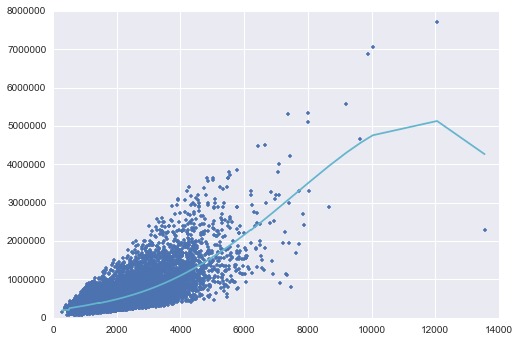

In [9]:
fit15_deg_poly(data, l2_small_penalty)

## observe overfitting

The polynomial fit of degree 15 changed wildly whenever the data changed. In particular, when we split the data and fit the model of degree 15, the result came out to be very different for each subset. The model had a *high variance*. This is where ridge regression kicks in because it reduces such variance. But first, we will reproduce such cases.

First, split the data into split the data into four subsets of roughly equal size and call them `set_1`, `set_2`, `set_3`, and `set_4`. 

In [10]:
idx = np.random.rand(len(data))<0.5
semi_split1 = data[idx]; semi_split2 = data[~idx]
idx = np.random.rand(len(semi_split1))<0.5
set_1 = semi_split1[idx]; set_2 = semi_split1[~idx]
idx = np.random.rand(len(semi_split2))<0.5
set_3 = semi_split2[idx]; set_4 = semi_split2[~idx]

Next, fit a 15th degree polynomial on `set_1`, `set_2`, `set_3`, and `set_4`, using 'sqft_living' to predict prices. Print the weights and make a plot of the resulting model.

intercept [ 214847.27784093]
coefficient [[  8.79395504e+01  -8.91792713e-03   1.73505356e-05  -1.63867300e-09
   -9.52928073e-15   3.41267009e-16  -1.09453289e-15   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]]


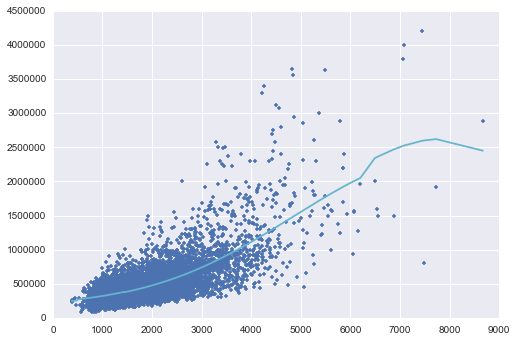

In [11]:
#set 1
fit15_deg_poly(set_1, l2_small_penalty)

intercept [ 117345.07723391]
coefficient [[  2.19657759e+02  -5.45342928e-02   2.00656617e-05  -1.20189180e-09
   -1.04445880e-14   3.91844475e-16  -1.28687054e-15   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]]


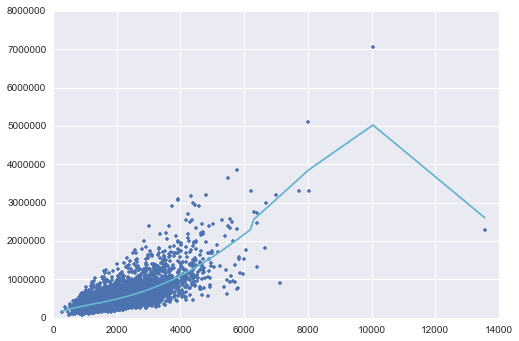

In [12]:
#set 2
fit15_deg_poly(set_2, l2_small_penalty)

intercept [ 274777.57344825]
coefficient [[ -1.79365225e+02   1.48652979e-01  -2.01886970e-05   1.32309772e-09
    2.69638258e-14   5.23834725e-16  -1.12635400e-14   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]]


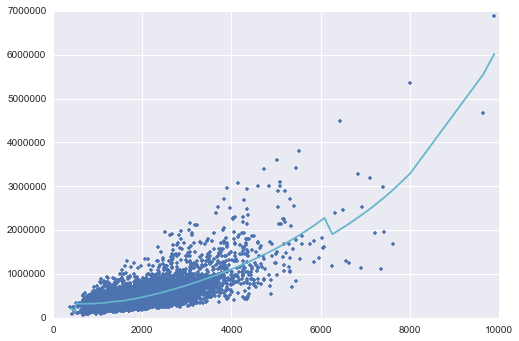

In [13]:
#set 3
fit15_deg_poly(set_3, l2_small_penalty)

intercept [ 275790.92011891]
coefficient [[ -9.87019267e+01   1.04674177e-01  -9.05370886e-06   4.31084780e-10
   -1.97719200e-14   3.26295135e-16  -5.90832396e-15   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]]


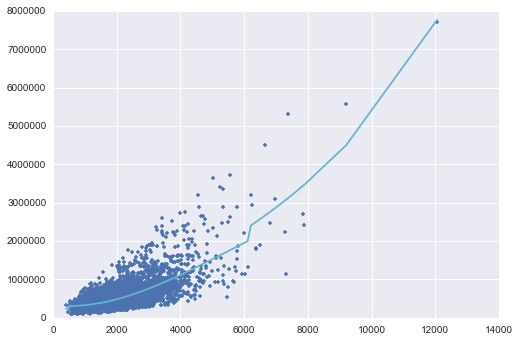

In [14]:
#set 4
fit15_deg_poly(set_4, l2_small_penalty)

The four curves should differ from one another a lot, as should the coefficients you learned.

## ridge regression comes to rescue

Generally, whenever we see weights change so much in response to change in data, we believe the variance of our estimate to be large. Ridge regression aims to address this issue by penalising "large" weights. Note that weights of `model15` looked quite small, but they are not that small because 'sqft_living' input is in the order of thousands.

With the argument `l2_penalty=1e5`, fit a 15th-order polynomial model on `set_1`, `set_2`, `set_3`, and `set_4`. Other than the change in the `l2_penalty` parameter, the code should be the same as the experiment above.

In [15]:
#define new l2 penaly 
l2_penalty = 1e10

intercept [ 250818.50246403]
coefficient [[  8.81891273e-02   3.30201687e-02   9.44020901e-06  -1.14140943e-09
   -8.46120591e-15  -1.61276169e-17  -3.47763588e-15   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]]


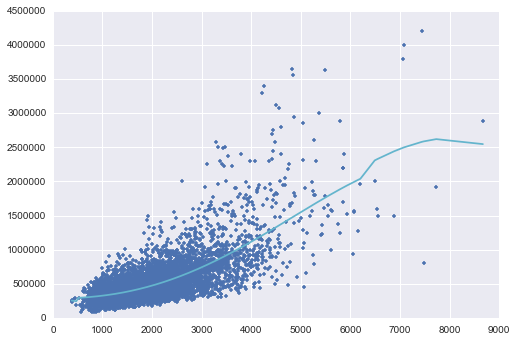

In [16]:
#set 1
fit15_deg_poly(set_1, l2_penalty)

intercept [ 215546.17905305]
coefficient [[  4.51670991e-01   2.93502739e-02   8.46473490e-06  -7.19484779e-10
   -1.95592769e-14  -1.39990461e-15  -8.48861065e-15   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]]


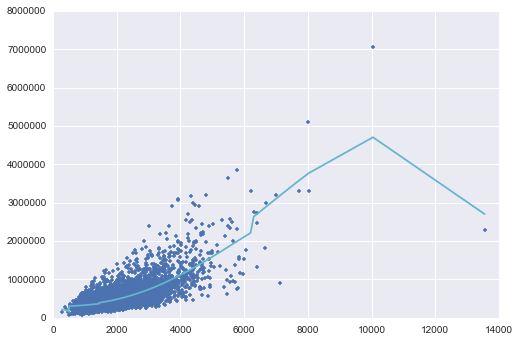

In [17]:
#set 2
fit15_deg_poly(set_2, l2_penalty)

intercept [ 187052.22395021]
coefficient [[ -2.49140949e-01   7.12380348e-02  -7.53020689e-06   6.58253134e-10
    3.17578659e-14   1.49678286e-15  -7.20349010e-15   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]]


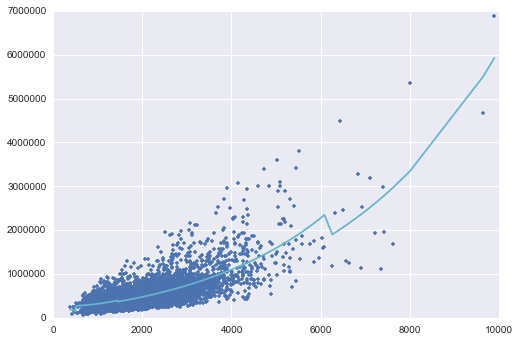

In [18]:
#set 3
fit15_deg_poly(set_3, l2_penalty)

intercept [ 229258.33434574]
coefficient [[ -1.74749728e-01   6.50438805e-02  -3.20023745e-06   1.65131759e-10
   -1.60408116e-14   9.99168000e-16  -3.15793547e-15   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]]


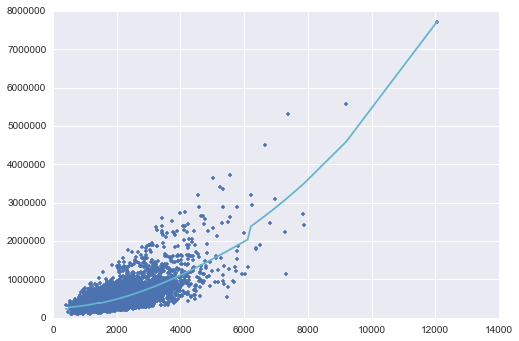

In [19]:
#set 4
fit15_deg_poly(set_4, l2_penalty)

intercept [ 275790.92011891]
coefficient [[ -9.87019267e+01   1.04674177e-01  -9.05370886e-06   4.31084780e-10
   -1.97719200e-14   3.26295135e-16  -5.90832396e-15   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]]


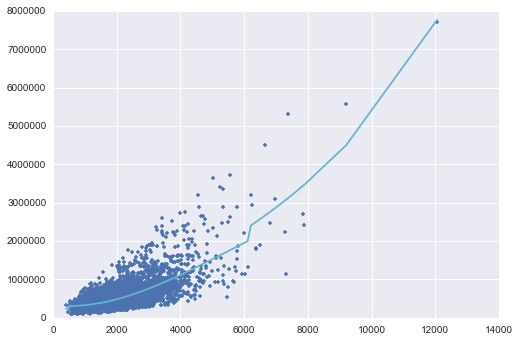

In [20]:
#set 4
fit15_deg_poly(set_4, l2_small_penalty)

## selecting an L2 penalty via cross-validation

As seen, with randon L2 parameter, we cannot see obvious improvement in our dataset. The L2 penalty is a "magic" parameter we need to select. We could use the validation set approach but that approach has a major disadvantage: it leaves fewer observations available for training. **Cross-validation** seeks to overcome this issue by using all of the training set in a smart way.

We will implement a kind of cross-validation called **k-fold cross-validation**. The method gets its name because it involves dividing the training set into k segments of roughtly equal size. Similar to the validation set method, we measure the validation error with one of the segments designated as the validation set. The major difference is that we repeat the process k times as follows:

> Set aside segment 0 as the validation set, and fit a model on rest of data, and evalutate it on this validation set<br>
> Set aside segment 1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set<br>
> ...<br>
> Set aside segment k-1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set

After this process, we compute the average of the k validation errors, and use it as an estimate of the generalization error. Notice that  all observations are used for both training and validation, as we iterate over segments of data. 

To estimate the generalization error well, it is crucial to shuffle the training data before dividing them into segments.

In [21]:
train_valid_shuffled = data.iloc[np.random.permutation(len(data))]
train_valid_shuffled.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21183,5528600005,20150327T000000,272167,2,2.50,1620,3795,2.0,0,0,...,7,1620,0,2014,0,98027,47.5321,-122.034,1620,6000
8673,4151800530,20141028T000000,1090000,4,2.50,2780,6837,2.0,0,0,...,9,2780,0,2004,0,98033,47.6660,-122.201,1160,6837
9277,8129700644,20140703T000000,715000,3,4.00,2080,2250,3.0,0,4,...,8,2080,0,1997,0,98103,47.6598,-122.355,2080,2250
6677,2795000080,20140919T000000,535100,3,2.25,2070,7207,1.0,0,0,...,8,1720,350,1973,0,98177,47.7735,-122.371,2350,7980
1369,3374300070,20140623T000000,334000,4,1.50,1150,9360,1.5,0,0,...,6,1150,0,1970,0,98034,47.7197,-122.173,1480,8155


Once the data is shuffled, we divide it into equal segments. Each segment should receive `n/k` elements, where `n` is the number of observations in the training set and `k` is the number of segments. Since the segment 0 starts at index 0 and contains `n/k` elements, it ends at index `(n/k)-1`. The segment 1 starts where the segment 0 left off, at index `(n/k)`. With `n/k` elements, the segment 1 ends at index `(n*2/k)-1`. Continuing in this fashion, we deduce that the segment `i` starts at index `(n*i/k)` and ends at `(n*(i+1)/k)-1`.

With this pattern in mind, we write a short loop that prints the starting and ending indices of each segment, just to make sure you are getting the splits right.

In [22]:
n = len(train_valid_shuffled)
k = 10 # 10-fold cross-validation

for i in xrange(k):
    start = (n*i)/k
    end = (n*(i+1))/k-1
    print i, (start, end)

0 (0, 2160)
1 (2161, 4321)
2 (4322, 6482)
3 (6483, 8644)
4 (8645, 10805)
5 (10806, 12966)
6 (12967, 15128)
7 (15129, 17289)
8 (17290, 19450)
9 (19451, 21612)


Let's familiarise ourselves with array slicing with dataframe. To extract a continuous slice from an data, use colon in square brackets. For instance, the following cell extracts rows 0 to 9 of `train_valid_shuffled`. Notice that the first index (0) is included in the slice but the last index (10) is omitted.

In [23]:
tmp_df = train_valid_shuffled[0:10] # rows 0 to 9
tmp_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21183,5528600005,20150327T000000,272167,2,2.50,1620,3795,2.0,0,0,...,7,1620,0,2014,0,98027,47.5321,-122.034,1620,6000
8673,4151800530,20141028T000000,1090000,4,2.50,2780,6837,2.0,0,0,...,9,2780,0,2004,0,98033,47.6660,-122.201,1160,6837
9277,8129700644,20140703T000000,715000,3,4.00,2080,2250,3.0,0,4,...,8,2080,0,1997,0,98103,47.6598,-122.355,2080,2250
6677,2795000080,20140919T000000,535100,3,2.25,2070,7207,1.0,0,0,...,8,1720,350,1973,0,98177,47.7735,-122.371,2350,7980
1369,3374300070,20140623T000000,334000,4,1.50,1150,9360,1.5,0,0,...,6,1150,0,1970,0,98034,47.7197,-122.173,1480,8155
13586,1226059101,20140701T000000,502000,3,2.25,1600,45613,2.0,0,0,...,8,1600,0,1983,0,98072,47.7523,-122.117,2320,43005
16297,9346900170,20140922T000000,615000,4,2.25,2330,7020,1.0,0,0,...,8,1450,880,1973,0,98006,47.5620,-122.139,2330,8500
1101,2197600451,20141105T000000,631000,5,2.00,2270,2400,2.0,0,0,...,7,2270,0,1905,0,98122,47.6051,-122.319,1320,2400
15516,579000595,20140906T000000,724000,2,1.00,1560,5000,1.5,0,1,...,7,1560,0,1942,0,98117,47.7006,-122.386,2620,5400
3013,3423049209,20150318T000000,200450,3,1.00,970,9130,1.0,0,0,...,6,970,0,1957,0,98188,47.4369,-122.272,1000,8886


Now, we'd like to get indexes from this slide dataframe. This can be done as follow.

In [24]:
tmp_df.index.tolist()

[21183, 8673, 9277, 6677, 1369, 13586, 16297, 1101, 15516, 3013]

After we can retrieve the index of our samll dataframe which will be used for validation set, now we'd like to get the rest to use as training set.

In [25]:
idx = tmp_df.index.tolist()
allidx = train_valid_shuffled.index.tolist()
print(len(data))
print(len(train_valid_shuffled.ix[idx]))
print(len(train_valid_shuffled.ix[list(set(allidx)-set(idx))]))

21613
10
21603


Now let's extract individual segments with array slicing. we should consider the scenario where we group the houses in the `train_valid_shuffled` dataframe into k=10 segments of roughly equal size, with starting and ending indices computed as above.
Just for fun, let's extract the fourth segment (segment 3) and assign it to a variable called `validation4`.

Now we are ready to implement k-fold cross-validation. We will write a function that computes k validation errors by designating each of the k segments as the validation set. It will accept parameters (i) `k`, (ii) `l2_penalty`, (iii) dataframe, (iv) name of output column (e.g. `price`) and (v) list of feature names. The function will return the average validation error using k segments as validation sets.

* For each i in [0, 1, ..., k-1]:
  > * Compute starting and ending indices of segment i and call 'start' and 'end'
  > * Form validation set by taking a slice (start:end+1) from the data.
  > * Form training set by appending slice (end+1:n) to the end of slice (0:start).
  > * Train a linear model using training set just formed, with a given l2_penalty
  > * Compute validation error using validation set just formed

In [90]:
def k_fold_cross_validation(k, l2_penalty, data, output, features_list):
    errors = []
    n = len(data)
    for i in xrange(k):
        start = (n*i)/k
        end = (n*(i+1))/k-1
        # get first fold
        valid = data[start:end]
        first_fold = data[0:start-1]
        remainder_fold = data[end+1:]
        train = first_fold.append(remainder_fold)
        # train model
        # create linear regression object
        reg = Ridge(alpha=l2_penalty, solver='svd')
        # train model
        reg.fit(train[features_list], train.iloc[:,(len(train.columns)-1)].to_frame())
        # prediction
        predicted = reg.predict(valid[features_list])
        sse = (predicted- valid[output])**2
        errors.append(np.mean(sse))
    mse = np.mean(list(errors))
    #print("l2_penalty: %s, \n\t Average MSE: $%.6f" % (l2_penalty, mse))
    return mse

Now that we have a function to compute the average validation error for a model, we can write a loop to find the model that minimizes the average validation error. Now let's write a loop that does the following:
* We will again be aiming to fit a 15th-order polynomial model using the `sqft_living` input
* For `l2_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, you can use this Numpy function: `np.logspace(1, 7, num=13)`.)
    * Run 10-fold cross-validation with `l2_penalty`
* Investigate which L2 penalty produced the lowest average validation error.

Note: since the degree of the polynomial is now fixed to 15, to make things faster, we should generate polynomial features in advance and re-use them throughout the loop. 
Note2: make sure to use `train_valid_shuffled` when generating polynomial features!

In [93]:
poly15_data = polynomial_dataframe(pd.DataFrame(train_valid_shuffled["sqft_living"]), 15)
fifteen_features = list(poly15_data.columns.values)# get the name of the features
poly15_data['price'] = train_valid_shuffled['price'] # add price to the data since it's the target
    
results = []

for l2_penalty in np.logspace(1, 7, num=13):
    average_error = k_fold_cross_validation(10, l2_penalty, poly15_data, ['price'], fifteen_features)
    results.append((l2_penalty, average_error))
pd.DataFrame(results, columns=["penalty", "error"])

,penalty,error
0,10.000000,6.630754e+10
1,31.622777,6.630754e+10
2,100.000000,6.630754e+10
3,316.227766,6.630754e+10
4,1000.000000,6.630753e+10
5,3162.277660,6.630750e+10
6,10000.000000,6.630742e+10
7,31622.776602,6.630716e+10
8,100000.000000,6.630633e+10
9,316227.766017,6.630372e+10


***QUIZ QUESTIONS:  What is the best value for the L2 penalty according to 10-fold validation?***

You may find it useful to plot the k-fold cross-validation errors you have obtained to better understand the behavior of the method.  

In [ ]:
# Plot the l2_penalty values in the x axis and the cross-validation error in the y axis.
# Using plt.xscale('log') will make your plot more intuitive.



Once you found the best value for the L2 penalty using cross-validation, it is important to retrain a final model on all of the training data using this value of `l2_penalty`. This way, your final model will be trained on the entire dataset.

***QUIZ QUESTION: Using the best L2 penalty found above, train a model using all training data. What is the RSS on the TEST data of the model you learn with this L2 penalty? ***